In [1]:
import numpy as np
import matplotlib.pyplot as plt

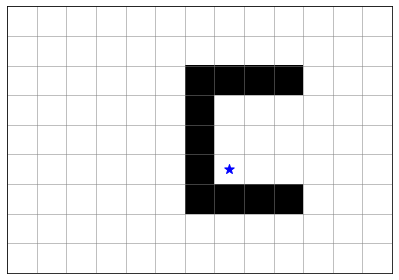

In [2]:
# define maze
maze = np.zeros((9, 13))

# place walls
maze[2, 6:10] = 1
maze[-3, 6:10] = 1
maze[2:-3, 6] = 1

# define start
start = [5, 7]

def plot_maze(maze):
    plt.imshow(maze, cmap='binary')

    # draw thin grid
    for i in range(maze.shape[0]):
        plt.plot([-0.5, maze.shape[1]-0.5], [i-0.5, i-0.5], c='gray', lw=0.5)
    for i in range(maze.shape[1]):
        plt.plot([i-0.5, i-0.5], [-0.5, maze.shape[0]-0.5], c='gray', lw=0.5)

    plt.xticks([])
    plt.yticks([])

plot_maze(maze)
plt.scatter(start[1], start[0], marker='*', color='blue', s=100)
plt.tight_layout()
# plt.savefig('maze.png')
plt.show()

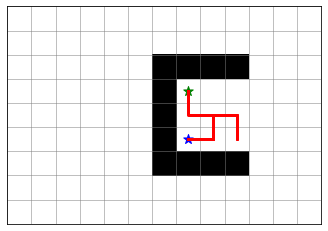

In [7]:
####################################
############## Part 1 ##############
####################################


def random_walk(maze, start, n_steps):
    # perform a single random walk in the given maze, starting from start, performing n_steps random moves
    # moves into the wall and out of the maze boundary are not possible

    # initialize list to store positions
    positions = [start]
    
    # define possible moves as dictionary 
    moves = {
        'up': (0, -1),
        'down': (0, 1),
        'left': (-1, 0),
        'right': (1, 0)
    }
    
    # perform random steps
    for _ in range(n_steps):
        # get current position
        current_position = positions[-1].copy()  # get current position
        valid_move_found = False  # flag to track if a valid move is made
        
        # try random moves until a valid move is found
        while not valid_move_found:
            move = np.random.choice(['up', 'down', 'left', 'right'])
            dx, dy = moves[move]
            new_position = [current_position[0] + dx, current_position[1] + dy]
            
            # check if new_position is within maze boundaries and not a wall
            if (0 <= new_position[0] < maze.shape[0] and  # x boundary check
                0 <= new_position[1] < maze.shape[1] and  # y boundary check
                maze[new_position[0], new_position[1]] == 0):  # check if not a wall
                # if move is valid, append new_position to positions
                positions.append(new_position)
                valid_move_found = True  # set flag to exit loop after valid move

    # return a list of length n_steps + 1, containing the starting position and all subsequent locations as e.g. tuples or size (2) arrays 
    return positions

def plot_path(maze, path):
    # plot a maze and a path in it
    plot_maze(maze)
    path = np.array(path)
    plt.plot(path[:, 1], path[:, 0], c='red', lw=3)
    plt.scatter(path[0, 1], path[0, 0], marker='*', color='blue', s=100)
    plt.scatter(path[-1, 1], path[-1, 0], marker='*', color='green', s=100)
    plt.show()

# plot a random path
path = random_walk(maze, start, 10)
plot_path(maze, path)

In [ ]:
####################################
############## Part 2 ##############
####################################


def learn_from_traj(succ_repr, trajectory, gamma=0.98, alpha=0.02):
    # Write a function to update a given successor representation (for the state at which the trajectory starts) using an example trajectory
    # using discount factor gamma and learning rate alpha

    TODO...

    # return the updated successor representation
    return succ_repr

# initialize successor representation
succ_repr = np.zeros_like(maze)

# sample a whole bunch of trajectories (reduce this number if this code takes too long, but it shouldn't take longer than a minute with reasonable code)
for i in range(5001):
    # sample a path (we use 340 steps here to sample states until the discounting becomes very small)
    path = random_walk(maze, start, 340)
    # update the successor representation
    succ_repr = learn_from_traj(succ_repr, path, alpha=0.02)  # choose a small learning rate

    # occasionally plot it
    if i in [0, 10, 100, 1000, 5000]:
        plot_maze(maze)
        plt.imshow(succ_repr, cmap='hot')
        # if i == 5000:
        #     plt.savefig("empirical")
        plt.show()

In [ ]:
####################################
############## Part 3 ##############
####################################


def compute_transition_matrix(maze):
    # for a given maze, compute the transition matrix from any state to any other state under a random walk policy
    # (you will need to think of a good way to map any 2D grid coordinates onto a single number for this)

    # create a matrix over all state pairs
    transitions = np.zeros(TODO...)

    # iterate over all states, filling in the transition probabilities to all other states on the next step (only one step into the future)
    TODO...
    
    # normalize transitions if neccessary
    TODO...

    # remove NaNs if necessary
    TODO...

    return transitions

In [ ]:
####################################
############## Part 4 ##############
####################################


def compute_sr(transitions, i, j, gamma=0.98):
    # given a transition matrix and a specific state (i, j), compute the successor representation of that state with discount factor gamma

    # initialize things (better to represent the current discounted occupancy as a vector here)
    current_discounted_occupancy = np.zeros(TODO...)
    total = current_discounted_occupancy.copy()
    TODO...

    # iterate for a number of steps
    for _ in range(340):
        TODO...

    # return the successor representation, maybe reshape your vector into the maze shape now
    return total.reshape(TODO...)

transitions = compute_transition_matrix(maze)

# compute state representation for start state
i, j = start
sr = compute_sr(transitions, i, j, 0.98)

# plot state representation
plot_maze(maze)
plt.imshow(sr, cmap='hot')
# plt.savefig("transition_iterate")
plt.show()

In [ ]:
############################################
############## Part 5 (Bonus) ##############
############################################

# You're on your own now